# **Elliot Richardson's Project 2 Code**

## Table of contents
[I. Reading in and cleaning the data](#Step-1:-Read-in-and-clean)

[II. Exploratory analysis of the data](#Step-2:-Exploratory-analysis)

[III. Feature selection for modeling](#Step-3:-Feature-Selection)

[IV. Experimenting with various models](#Step-4:-Modeling!)

[V. Model selection and conclusion](#Step-5:-Conclusions)



## Problem Statement: 
For this project, I am a consultant hired by a real estate company to help them predict market prices for houses in the Ames area. Using data they collect in the field, I was hired to construct a model that would return a predicted sale price for each house so they could cross reference their gut assumptions with something more objective.

## Step 1: Read in and clean

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, RobustScaler
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.max_rows", None, "display.max_columns", None)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

I'm combining the test and train datasets to ensure that they will have the same columns and data types at the end of this process.

In [7]:
test = pd.read_csv('./datasets/test.csv')
train = pd.read_csv('./datasets/train.csv')

test['SalePrice'] = np.NaN

train['dataset'] = 'train'
test['dataset'] = 'test'

datasets = [train,test]
df = pd.concat(datasets)
df = df.reset_index(drop=True)

df.columns = [col.replace(' ', '_').lower() for col in df.columns]

df.head(3)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,dataset
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,train
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,train
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,train


There are two types of "attributes" that are split into multiple columns: (a) `condition_1` and `condition_2` that indicate whether the house is near a main road, railroad, or "positive feature", and (b) `bsmtfin_type_1` and `bsmtfin_type_2` which indicate the quality of the basement as well as the purpose. I am going to parse these out into separate columns for easier analysis later.

In [8]:
feeder = [0]*(df.shape[0])
artery = [0]*(df.shape[0])
ns_rail = [0]*(df.shape[0])
ew_rail = [0]*(df.shape[0])
pos_feat = [0]*(df.shape[0])

for i in range(df.shape[0]):
    if df.loc[i,'condition_1'] == 'Feedr':
        feeder[i] = 1        
    elif df.loc[i,'condition_1'] == 'Artery':
        artery[i] = 1           
    elif df.loc[i,'condition_1'] in ['RRAn','RRNn']:
        ns_rail[i] = 1
    elif df.loc[i,'condition_1'] in ['RRAe','RRNe']:
        ew_rail[i] = 1        
    elif df.loc[i,'condition_1'] in ['PosA','PosN']:
        pos_feat[i] = 1

        
for i in range(df.shape[0]):
    if df.loc[i,'condition_2'] == 'Feedr':
        feeder[i] = 1        
    elif df.loc[i,'condition_2'] == 'Artery':
        artery[i] = 1        
    elif df.loc[i,'condition_2'] in ['RRAn','RRNn']:
        ns_rail[i] = 1        
    elif df.loc[i,'condition_2'] in ['RRAe','RRNe']:
        ew_rail[i] = 1        
    elif df.loc[i,'condition_2'] in ['PosA','PosN']:
        pos_feat[i] = 1
        
df['feeder'] = feeder
df['artery'] = artery
df['ns_rail'] = ns_rail
df['ew_rail'] = ew_rail
df['pos_feat'] = pos_feat

In [9]:
bsmt_lq_qual = [0]*df.shape[0]
bsmt_rec_room = [0]* df.shape[0]

for i in range(df.shape[0]):
    if df.loc[i,'bsmtfin_type_1'] == 'GLQ':
        bsmt_lq_qual[i] = 5
    elif df.loc[i,'bsmtfin_type_1'] == 'ALQ':
        bsmt_lq_qual[i] = 4
    elif df.loc[i,'bsmtfin_type_1'] == 'BLQ':
        bsmt_lq_qual[i] = 3
    elif df.loc[i,'bsmtfin_type_1'] == 'LwQ':
        bsmt_lq_qual[i] = 2
    elif df.loc[i,'bsmtfin_type_1'] == 'Unf':
        bsmt_lq_qual[i] = 1
    elif df.loc[i,'bsmtfin_type_1'] == 'NA':
        bsmt_lq_qual[i] = 0
    elif df.loc[i,'bsmtfin_type_1'] == 'Rec':
        bsmt_rec_room = 1
        
for i in range(df.shape[0]):
    if df.loc[i,'bsmtfin_type_2'] == 'GLQ':
        bsmt_lq_qual[i] = 5
    elif df.loc[i,'bsmtfin_type_2'] == 'ALQ':
        bsmt_lq_qual[i] = 4
    elif df.loc[i,'bsmtfin_type_2'] == 'BLQ':
        bsmt_lq_qual[i] = 3
    elif df.loc[i,'bsmtfin_type_2'] == 'LwQ':
        bsmt_lq_qual[i] = 2
    elif df.loc[i,'bsmtfin_type_2'] == 'Unf':
        bsmt_lq_qual[i] = 1
    elif df.loc[i,'bsmtfin_type_2'] == 'NA':
        bsmt_lq_qual[i] = 0
    elif df.loc[i,'bsmtfin_type_2'] == 'Rec':
        bsmt_rec_room = 1        
        
df['bsmt_lq_qual'] = bsmt_lq_qual
df['bsmt_rec_room'] = bsmt_rec_room

In [10]:
df.drop(columns = ['condition_1','condition_2',
                   'bsmtfin_type_1','bsmtfin_type_2'], inplace=True)

df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,dataset,feeder,artery,ns_rail,ew_rail,pos_feat,bsmt_lq_qual,bsmt_rec_room
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,533.0,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,train,0,0,0,1,0,1,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,637.0,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,train,0,0,0,0,0,1,1
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,731.0,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,train,0,0,0,0,0,1,1
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,0.0,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000.0,train,0,0,0,0,0,1,1
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,0.0,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500.0,train,0,0,0,0,0,1,1


There are also many columns that rate the quality of a certain attribute of the house. I am going to convert these into scales from 0-5 or 0-10 because I think that makes more sense than converting them into dummy columns. There is one scale that is super common so I can do several at once in a for loop, but others I will have to address individually.

In [11]:
quality_dict = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0
}

quality_cols = ['bsmt_qual','bsmt_cond','exter_qual','exter_cond',
            'fireplace_qu','garage_qual','garage_cond',
           'heating_qc', 'kitchen_qual','pool_qc']

for col in quality_cols:
    df[col] = df[col].map(quality_dict)

In [12]:
fence_dict = {
    'GdPrv': 2,
    'GdWo': 2,
    'MnPrv': 1,
    'MnWw': 1,
    'NA': 0
}

df['fence'] = df['fence'].map(fence_dict)

In [13]:
func_dict = {
    'Typ': 5,
    'Min1': 4,
    'Min2': 4,
    'Mod': 3,
    'Maj1': 2,
    'Maj2': 2,
    'Sev': 1,
    'Sal': 0
}

df['functional'] = df['functional'].map(func_dict)

In [14]:
slope_dict = {
    'Gtl': 1,
    'Mod': 2,
    'Sev': 3
}

df['land_slope'] = df['land_slope'].map(slope_dict)

In [15]:
shape_dict = {
    'Reg': 0,
    'IR1': 1,
    'IR2': 2,
    'IR3': 3
}

df['lot_shape'] = df['lot_shape'].map(shape_dict)

In [16]:
exp_dict = {
    'Gd': 4,
    'Av': 3,
    'Mn': 2,
    'No': 1,
    'NA': 0
}

df['bsmt_exposure'] = df['bsmt_exposure'].map(exp_dict)

In [17]:
finish_dict = {
    'Fin': 3,
    'RFn': 2,
    'Unf': 1,
    'NA': 0
}

df['garage_finish'] = df['garage_finish'].map(finish_dict)

In [18]:
style_dict = {
    '1Story': 1,
    '1.5Fin': 1.5,
    '1.5Unf': 1.5,
    '2Story': 2,
    '2.5Fin': 2.5,
    '2.5Unf': 2.5,
    'SFoyer': 2,
    'SLvl': 3
}

df['house_style'] = df['house_style'].map(style_dict)

There are also a couple of binary columns and I am going to edit them to reflect that.

In [19]:
df['central_air'] = df['central_air'].map({'Y':1,
                                           'N':0})

df['paved_street'] = df['street'].map({'Pave': 1,
                                        'Grvl': 0})

In [20]:
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,dataset,feeder,artery,ns_rail,ew_rail,pos_feat,bsmt_lq_qual,bsmt_rec_room,paved_street
0,109,533352170,60,RL,NaN,13517,Pave,NaN,1,Lvl,AllPub,CulDSac,1,Sawyer,1Fam,2.0,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3.0,3.0,1.0,533.0,0.0,192.0,725.0,GasA,5,1,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,5,0,NaN,Attchd,1976.0,2.0,2.0,475.0,3.0,3.0,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0,train,0,0,0,1,0,1,1,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,1,Lvl,AllPub,CulDSac,1,SawyerW,1Fam,2.0,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4.0,3.0,1.0,637.0,0.0,276.0,913.0,GasA,5,1,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,5,1,3.0,Attchd,1997.0,2.0,2.0,559.0,3.0,3.0,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0,train,0,0,0,0,0,1,1,1
2,153,535304180,20,RL,68.0,7922,Pave,NaN,0,Lvl,AllPub,Inside,1,NAmes,1Fam,1.0,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3.0,3.0,1.0,731.0,0.0,326.0,1057.0,GasA,3,1,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,5,0,NaN,Detchd,1953.0,1.0,1.0,246.0,3.0,3.0,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0,train,0,0,0,0,0,1,1,1
3,318,916386060,60,RL,73.0,9802,Pave,NaN,0,Lvl,AllPub,Inside,1,Timber,1Fam,2.0,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4.0,3.0,1.0,0.0,0.0,384.0,384.0,GasA,4,1,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,5,0,NaN,BuiltIn,2007.0,3.0,2.0,400.0,3.0,3.0,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000.0,train,0,0,0,0,0,1,1,1
4,255,906425045,50,RL,82.0,14235,Pave,NaN,1,Lvl,AllPub,Inside,1,SawyerW,1Fam,1.5,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,PConc,2.0,4.0,1.0,0.0,0.0,676.0,676.0,GasA,3,1,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,5,0,NaN,Detchd,1957.0,1.0,2.0,484.0,3.0,3.0,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500.0,train,0,0,0,0,0,1,1,1


### Okay! Now I feel like the columns are as close to sensible data types and values as I will be able to get them. Time to fill (and drop?) some nulls!
I looked into the nulls for the following columns and discovered that they were null because the house didn't have that attribute at all. For example, a house without a garage would have `np.nan` in the `garage_type` column. I am going to replace those with 'None' in the categorical columns and a 0 in the quality scale columns. Before I do that, I am going to drop a few columns.

In [21]:
df.drop(columns = ['pid',             # we have the Id column
                   'ms_subclass',     # we have stories & year built elsewhere
                   'street',          # replaced w/ 'paved_street' 
                   'garage_yr_blt'    # there are other columns that reflect the quality/condition of the garage
                     ],               # and putting zero would be a huge outlier in a column of years
                    inplace=True)

In [22]:
def fill_w_none(list_of_cols):
    for col in list_of_cols:
        df[col].fillna('None',inplace=True)
        
fill_w_none(['fence','alley','misc_feature','garage_type','garage_finish','mas_vnr_type'])

def fill_w_zero(list_of_cols):
    for col in list_of_cols:
        df[col].fillna(0,inplace=True)

fill_w_zero(['pool_qc','fireplace_qu','garage_qual','garage_cond',
             'bsmt_qual','bsmt_cond','bsmt_exposure','mas_vnr_area','garage_area'])

In [23]:
df.isnull().sum()

id                   0
ms_zoning            0
lot_frontage       490
lot_area             0
alley                0
lot_shape            0
land_contour         0
utilities            0
lot_config           0
land_slope           0
neighborhood         0
bldg_type            0
house_style          0
overall_qual         0
overall_cond         0
year_built           0
year_remod/add       0
roof_style           0
roof_matl            0
exterior_1st         0
exterior_2nd         0
mas_vnr_type         0
mas_vnr_area         0
exter_qual           0
exter_cond           0
foundation           0
bsmt_qual            0
bsmt_cond            0
bsmt_exposure        0
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
heating              0
heating_qc           0
central_air          0
electrical           1
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
bsmt_full_bath       2
bsmt_half_bath       2
full_bath  

Other than `lot_frontage`, we barely have any nulls left (the `saleprice` nulls are from the test dataset!). I am going to try two methods of filling these nulls so we don't need to drop all ~500 columns. However, I am going to finish cleaning up the rest of the data first so I can use it to impute the missing values!

Upon Sophie's advice, I am going to drop the columns that are significantly unbalanced. If a column is dominated by one value, it isn't contributing much information to the model and I don't want to make a ton of unncessary dummy columns if I don't have to.

In [24]:
columns = list(df.columns)
numeric = list(df._get_numeric_data().columns)
nonnumeric = [col for col in columns if col not in numeric]

In [25]:
unbalanced_cols = []

for col in nonnumeric:
    ratio = df[col].value_counts(normalize=True).values[0]
    if ratio > 0.95:
        unbalanced_cols.append(col)

In [26]:
unbalanced_cols

['utilities', 'roof_matl', 'heating', 'misc_feature']

In [27]:
df.drop(columns=unbalanced_cols, inplace=True)

# resetting
columns = list(df.columns)
numeric = list(df._get_numeric_data().columns)
nonnumeric = [col for col in columns if col not in numeric]

Now that I have taken those columns out and cleaned the heck out of the rest of them, it's time to make some dummies :^) But really quick, I am going to get the `lot_frontage` means for each `lot_config` value, as well as the actual values for each of those columns, so I can use them later. Also, I'm going to save the neighborhoods and zoning columns for EDA!

In [28]:
means_by_config = df.loc[:,['lot_frontage','lot_config']].groupby('lot_config').mean()

config_dict = {config: means_by_config.loc[config,'lot_frontage'] 
               for config in list(means_by_config.index)}

lf_nulls = list(df['lot_frontage'].isnull())
lot_config = list(df['lot_config'])
lot_frontage = list(df['lot_frontage'])

In [29]:
neighborhoods = df.loc[df['dataset']=='train',['neighborhood','saleprice']]
zoning = df.loc[df['dataset']=='train',['ms_zoning','saleprice']]

In [30]:
# okay NOW it's dummy time 

for column in nonnumeric:
    df = pd.get_dummies(df,columns=[column],drop_first=True)

In [31]:
print('There are',len(df.columns),'columns in the clean dataframe!')
df.head()

There are 178 columns in the clean dataframe!


,id,lot_frontage,lot_area,lot_shape,land_slope,house_style,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,misc_val,mo_sold,yr_sold,saleprice,feeder,artery,ns_rail,ew_rail,pos_feat,bsmt_lq_qual,bsmt_rec_room,paved_street,ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,alley_None,alley_Pave,land_contour_HLS,land_contour_Low,land_contour_Lvl,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_PreCast,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Other,exterior_2nd_Plywood,exterior_2nd_PreCast,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,mas_vnr_type_BrkFace,mas_vnr_type_CBlock,mas_vnr_type_None,mas_vnr_type_Stone,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_None,garage_finish_2.0,garage_finish_3.0,garage_finish_None,paved_drive_P,paved_drive_Y,fence_2.0,fence_None,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,dataset_train
0,109,NaN,13517,1,1,2.0,6,8,1976,2005,289.0,4,3,3.0,3.0,1.0,533.0,0.0,192.0,725.0,5,1,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,5,0,0.0,2.0,475.0,3.0,3.0,0,44,0,0,0,0,0.0,0,3,2010,130500.0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1
1,544,43.0,11492,1,1,2.0,7,5,1996,1997,132.0,4,3,4.0,3.0,1.0,637.0,0.0,276.0,913.0,5,1,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,5,1,3.0,2.0,559.0,3.0,3.0,0,74,0,0,0,0,0.0,0,4,2009,220000.0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1
2,153,68.0,7922,0,1,1.0,5,7,1953,2007,0.0,3,4,3.0,3.0,1.0,731.0,0.0,326.0,1057.0,3,1,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,5,0,0.0,1.0,246.0,3.0,3.0,0,52,0,0,0,0,0.0,0,1,2010,109000.0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,

Since I am going to try two methods of filling the `lot_frontage` nulls, I am going to make some copies of my dataframe. I could probably just continue with the one but I was getting all confused and decided this was easier!

In [32]:
means = df.copy(deep=True)
impute = df.copy(deep=True)

### Filling `lot_frontage` 
**Method 1:** Imputing with an sklearn estimator. These variables will end with `_i` so they are distinguishable from the other method.

In [33]:
X_i = impute.drop(columns=['id','saleprice','dataset_train'])

imp = IterativeImputer()
imp.fit(X_i)
X_i = pd.DataFrame(imp.transform(X_i),columns=X_i.columns)

In [34]:
X_i.isnull().sum().sum() # yay!

0

In [35]:
i_df = df.loc[:,['id','saleprice','dataset_train']]
i_df = i_df.merge(X_i,left_index=True,right_index=True)
test_i = i_df[i_df['dataset_train'] == 0]
train_i = i_df[i_df['dataset_train'] == 1]

y_i = train_i['saleprice']
y_i_log = y_i.map(np.log)

**Method 2:** Calculating means for `lot_frontage` for each `lot_config` value and subbing those in for the null values based on the `lot_config` value in each row. The `lot_config` columns indicates where the house is relative to the street, i.e. on a corner or in the middle of a block, which definitely has an effect on the `lot_frontage` a.k.a the "linear feet of street connected to property" ([Kaggle](https://www.kaggle.com/c/dsir-202021214-e-project-2-regression-challenge/data)). These variables will end with `_m` so they are distinguishable from the other method.

To job your memory, here are the variables I created before:

In [36]:
config_dict    # these are the mean lot_frontage values for each config type

{'Corner': 82.69041769041769,
 'CulDSac': 56.30434782608695,
 'FR2': 61.276923076923076,
 'FR3': 79.3,
 'Inside': 67.11367292225201}

In [37]:
list(zip(lf_nulls, lot_config, lot_frontage)) # original columns and a T/F list indicating the location of nulls


[(True, 'CulDSac', nan),
 (False, 'CulDSac', 43.0),
 (False, 'Inside', 68.0),
 (False, 'Inside', 73.0),
 (False, 'Inside', 82.0),
 (False, 'Corner', 137.0),
 (False, 'Inside', 35.0),
 (True, 'Inside', nan),
 (True, 'Inside', nan),
 (False, 'Inside', 70.0),
 (False, 'Inside', 21.0),
 (False, 'Inside', 64.0),
 (False, 'FR2', 120.0),
 (False, 'Inside', 24.0),
 (False, 'Inside', 74.0),
 (False, 'Inside', 93.0),
 (False, 'Inside', 34.0),
 (False, 'Corner', 80.0),
 (False, 'Inside', 71.0),
 (False, 'Inside', 72.0),
 (False, 'Inside', 109.0),
 (False, 'Inside', 40.0),
 (False, 'Corner', 103.0),
 (True, 'Inside', nan),
 (False, 'Inside', 100.0),
 (False, 'Corner', 92.0),
 (False, 'Inside', 65.0),
 (True, 'Inside', nan),
 (False, 'Inside', 75.0),
 (False, 'Corner', 60.0),
 (False, 'Inside', 80.0),
 (True, 'Corner', nan),
 (False, 'CulDSac', 30.0),
 (False, 'Inside', 60.0),
 (False, 'Inside', 79.0),
 (False, 'Inside', 80.0),
 (False, 'Inside', 41.0),
 (False, 'Inside', 105.0),
 (False, 'Inside',

Now I am going to use those to fill the nulls in the `means` dataframe.

In [38]:
lot_fill = []

for i in range(len(lf_nulls)):
    
    config = lot_config[i]
    frontage = lot_frontage[i]
    
    if lf_nulls[i]:
        lot_fill.append(config_dict[config])
    else:
        lot_fill.append(frontage)
        
means['lot_frontage'] = lot_fill

test_m = means.loc[means['dataset_train'] == 0,:].copy(deep=True)
train_m = means.loc[means['dataset_train'] == 1,:].copy(deep=True)
train_m.dropna(inplace=True)

y_m = train_m['saleprice']
y_m_log = y_m.map(np.log)

## Wow, I think we are done cleaning??? Yeehaw, time to make some models!
 *Just kidding! Time to do some EDA.*

# Step 2: Exploratory analysis
Here are some charts I used to try to understand the relationship between some of the various features and our target, `saleprice`.

In [39]:
df.loc[:,['saleprice','lot_area']].sort_values('saleprice')

,saleprice,lot_area
1628,12789.0,9656
183,13100.0,14584
1309,34900.0,7879
1292,35000.0,8088
1518,35311.0,9000
1564,37900.0,5925
1428,39300.0,5000
408,40000.0,8500
103,44000.0,9392
1089,45000.0,5925


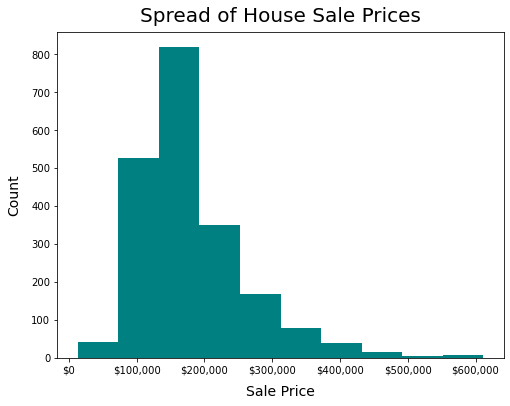

In [40]:
plt.figure(figsize=(8,6))
plt.hist(means['saleprice'],color='teal',rwidth=1)
plt.title('Spread of House Sale Prices',fontsize=20,pad=10)
plt.xlabel('Sale Price',fontsize=14,labelpad=10)
plt.ylabel('Count',fontsize=14,labelpad=10)
plt.xticks(ticks=range(0,600001,100000),
           labels=['$0','$100,000','$200,000','$300,000','$400,000','$500,000','$600,000']);

This histogram can help us get a feel for the variability of `saleprice` for houses in Ames. The values of `saleprice` range from \\$12,789 to \\$611,657. However, it isn't quite a normal distribution. There aren't many houses below \\$100,000, but there is a strong concentration of cases between \\$100,000 and \\$200,000. After that point, the number of houses in each bin decrease as the price range increases. This can help us understand and interpret the output of our models later, especially the root mean square error.

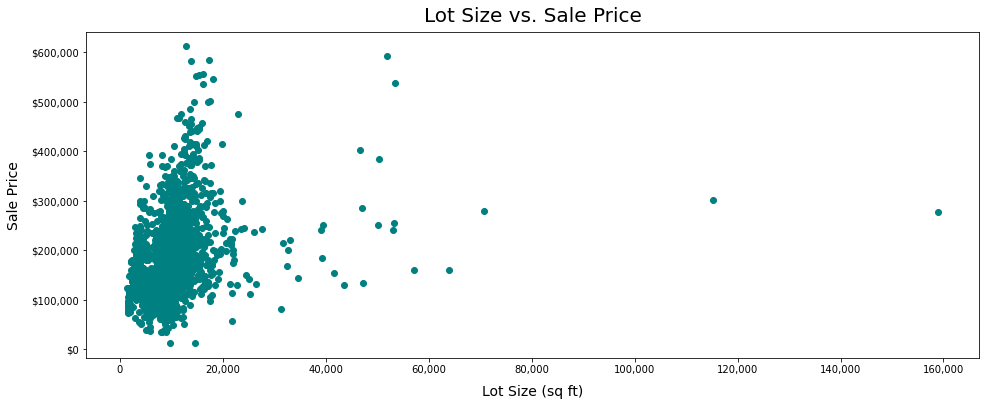

In [41]:
plt.figure(figsize=(16,6))
plt.scatter(means['lot_area'],means['saleprice'],color='teal')
plt.title('Lot Size vs. Sale Price',fontsize=20,pad=10)
plt.ylabel('Sale Price',fontsize=14,labelpad=10)
plt.xlabel('Lot Size (sq ft)',fontsize=14,labelpad=10)
plt.yticks(ticks=range(0,600001,100000),
           labels=['$0','$100,000','$200,000','$300,000','$400,000','$500,000','$600,000'])
plt.xticks(ticks=range(0,160001,20000),
           labels=['0','20,000','40,000','60,000','80,000','100,000','120,000','140,000','160,000']);

This plot can help us understand the relationship between lot size and sale price. It's a big tough to decipher here since most of the houses are crowded on the lower end of the x-axis, but it does look like there is a positive relationship between size and price, as we would expect. However, the outliers on the large end of the size spectrum are in the mid-range price-wise suggesting it isn't a simple linear relationship. 

In [42]:
means[means['lot_area'] > 100000]

,id,lot_frontage,lot_area,lot_shape,land_slope,house_style,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,misc_val,mo_sold,yr_sold,saleprice,feeder,artery,ns_rail,ew_rail,pos_feat,bsmt_lq_qual,bsmt_rec_room,paved_street,ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,alley_None,alley_Pave,land_contour_HLS,land_contour_Low,land_contour_Lvl,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_PreCast,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Other,exterior_2nd_Plywood,exterior_2nd_PreCast,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,mas_vnr_type_BrkFace,mas_vnr_type_CBlock,mas_vnr_type_None,mas_vnr_type_Stone,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_None,garage_finish_2.0,garage_finish_3.0,garage_finish_None,paved_drive_P,paved_drive_Y,fence_2.0,fence_None,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,dataset_train
471,2116,56.304348,159000,2,3,1.5,6,7,1958,2006,472.0,4,3,4.0,3.0,4.0,697.0,0.0,747.0,1444.0,4,1,1444,700,0,2144,0.0,1.0,2,0,4,1,4,7,5,2,3.0,2.0,389.0,3.0,3.0,0,98,0,0,0,0,0.0,500,6,2007,277000.0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1
694,2072,56.304348,115149,2,3,1.0,7,5,1971,2002,351.0,3,3,4.0,3.0,4.0,1219.0,0.0,424.0,1643.0,3,1,1824,0,0,1824,1.0,0.0,2,0,2,1,4,5,5,2,3.0,2.0,739.0,3.0,3.0,380,48,0,0,0,0,0.0,0,6,2007,302000.0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1
2264,957,150.000000,215245,3,3,1.0,7,5,1965,1965,0.0,3,3,4.0,3.0,4.0,1236.0,820.0,80.0,2136.0,3,1,2036,0,0,2036,2.0,0.0,2,0,3,1,3,8,5,2,4.0,2.0,513.0,3.0,3.0,0,0,0,0,0,0,0.0,0,6,2009,NaN,0,0,0,0,0,4,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,

These outliers for `lot_area` are all in low density residential areas (`ms_zoning_RL`) so I guess it makes sense that they might be larger than the high density residential areas. Perhaps the large swaths of lands are harder to maintain, so they aren't as expensive we might expect.

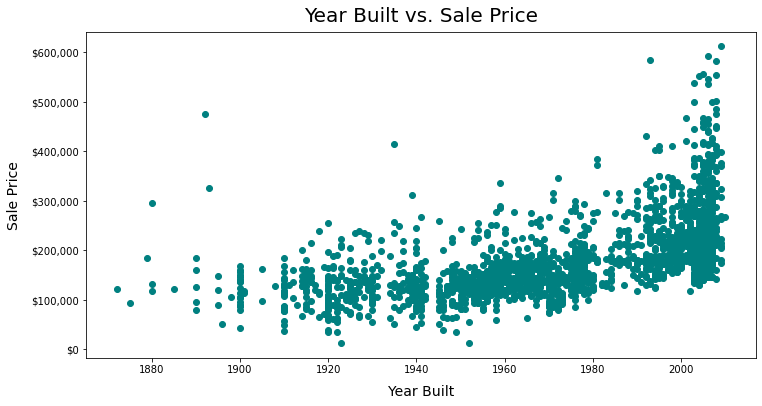

In [43]:
plt.figure(figsize=(12,6))
plt.scatter(means['year_built'],means['saleprice'],color='teal')
plt.title('Year Built vs. Sale Price',fontsize=20,pad=10)
plt.ylabel('Sale Price',fontsize=14,labelpad=10)
plt.xlabel('Year Built',fontsize=14,labelpad=10)
plt.yticks(ticks=range(0,600001,100000),
           labels=['$0','$100,000','$200,000','$300,000','$400,000','$500,000','$600,000']);

This chart helps us understand that there is a fairly straight forward relationship between year price and sale price. Newer houses are generally more expensive, but there are a few exceptions. A handful of older houses are in the higher end price-wise, which makes sense! Older houses can be very grand and beautiful but only if they have been meticulously maintained over the years, which is expensive!

In [67]:
nbrhd_means = neighborhoods.groupby('neighborhood').mean().sort_values('saleprice',ascending=True)

nbrhd_dict = {'Blmngtn': 'Bloomington Heights','Blueste': 'Bluestem',
                    'BrDale': 'Briardale','BrkSide': 'Brookside','ClearCr': 'Clear Creek',
                    'CollgCr': 'College Creek','Crawfor': 'Crawford','Edwards': 'Edwards',
                    'Gilbert': 'Gilbert','GrnHill': 'Green Hill','Greens': 'Greens',
                    'IDOTRR': 'Iowa DOT & Rail Road','Landmrk': 'Landmark', 'MeadowV': 'Meadow Village',
                    'Mitchel': 'Mitchell','NAmes': 'North Ames','NoRidge': 'Northridge',
                    'NPkVill': 'Northpark Villa','NridgHt': 'Northridge Heights','NWAmes': 'Northwest Ames',
                    'OldTown': 'Old Town','SWISU': 'South & West of ISU','Sawyer': 'Sawyer',
                    'SawyerW': 'Sawyer West','Somerst': 'Somerset','StoneBr': 'Stone Brook',
                    'Timber': 'Timberland','Veenker': 'Veenker'}

sorted_nticks = list(nbrhd_means.sort_values('saleprice', ascending=False).index)
sorted_nlabels = [nbrhd_dict[tick] for tick in sorted_nticks]

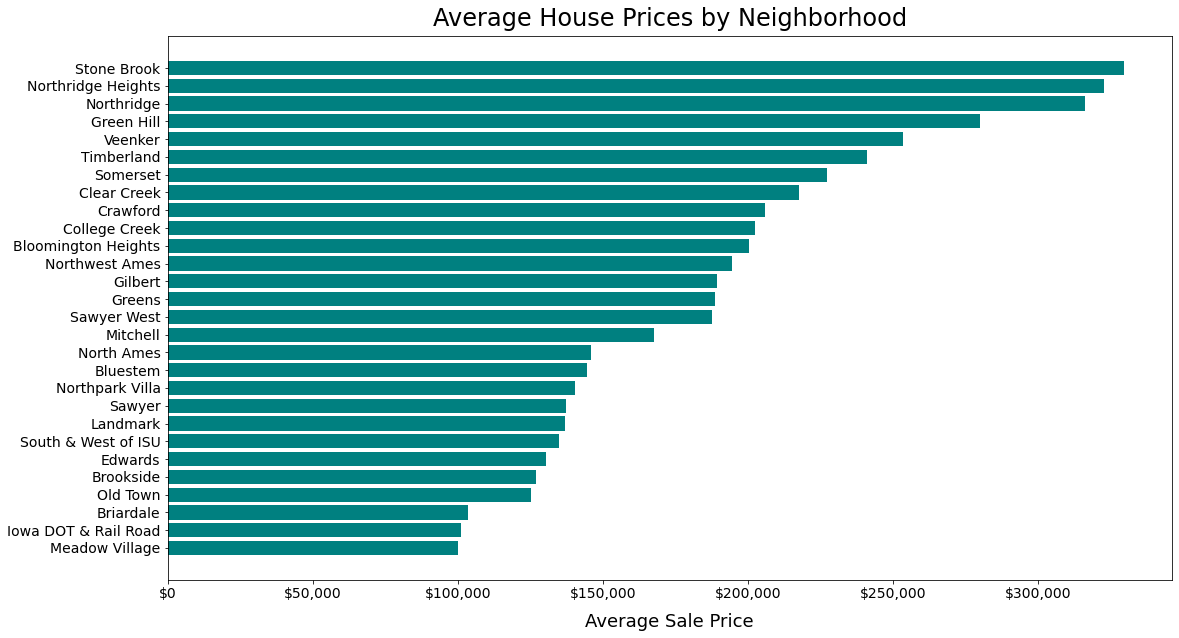

In [72]:
nbrhd_means = neighborhoods.groupby('neighborhood').mean().sort_values('saleprice',ascending=True)

plt.figure(figsize=(18,10))
plt.barh(nbrhd_means.index,nbrhd_means['saleprice'],color='teal')
plt.title('Average House Prices by Neighborhood',fontsize=24,pad=10)
plt.xlabel('Average Sale Price',fontsize=18,labelpad=12)
plt.yticks(ticks = sorted_nticks, labels = sorted_nlabels,fontsize=14)
plt.xticks(ticks=range(0,300001,50000),fontsize=14,
           labels=['$0','$50,000','$100,000','$150,000','$200,000','$250,000','$300,000']);

This bar chart helps us understand that there are pretty clear price differences between neighborhoods. This is presumably because some neighborhoods are more desirable areas than others, so the prices vary widely. This is promising because we can use the neighborhood as a predicting variable!

In [63]:
zone_means = zoning.groupby('ms_zoning').mean().sort_values('saleprice',ascending=True)


zone_dict = {'FV': 'Floating Village Residential', 'RL': 'Residential (Low Density)',
             'RH': 'Residential (High Density)','RM': 'Residential (Medium Density)',
            'C (all)': 'Commercial', 'I (all)': 'Industrial', 'A (agr)': 'Agricultural'}

sorted_zticks = list(zone_means.sort_values('saleprice', ascending=False).index)
sorted_zlabels = [zone_dict[tick] for tick in sorted_zticks]

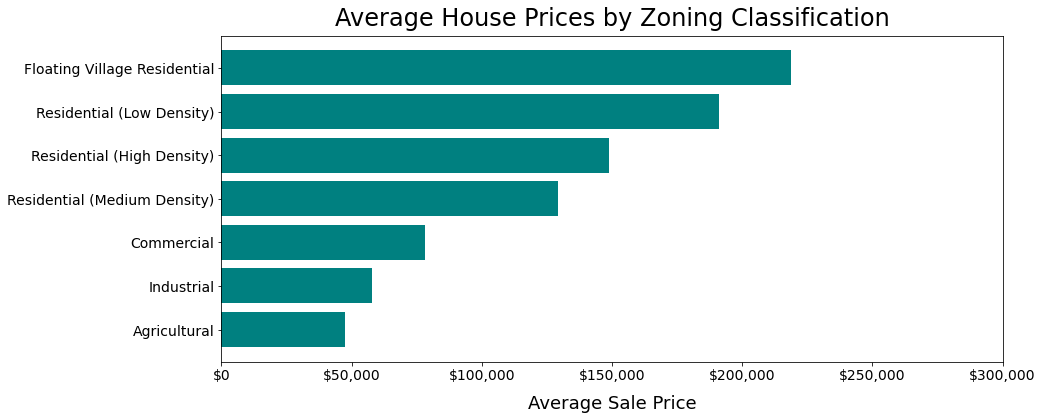

In [65]:
zone_means = zoning.groupby('ms_zoning').mean().sort_values('saleprice',ascending=True)

plt.figure(figsize=(14,6))
plt.barh(zone_means.index,zone_means['saleprice'],color='teal')
plt.title('Average House Prices by Zoning Classification',fontsize=24,pad=10)
plt.xlabel('Average Sale Price',fontsize=18,labelpad=12)
plt.yticks(ticks=sorted_zticks, fontsize=14, labels=sorted_zlabels)
plt.xticks(ticks=range(0,300001,50000),fontsize=14,
           labels=['$0','$50,000','$100,000','$150,000','$200,000','$250,000','$300,000']);

Similar to the neighborhood chart, this helps us understand that zoning classifications can have a significant effect on the sale price. It seems like the most desirable zoning classifications are FV and RL, which represent 'Floating Village Residential' and 'Residential Low Density' respectively. Then 'Residential High Density' and 'Residential Medium Density' (RH and RM) follow behind, and then 'Commercial','Industrial', and'Agriculture' (C, I, and A) are the lowest. This makes sense to me as most people would want to buy a house in a residential neighborhood but might prefer to have more space if possible. 

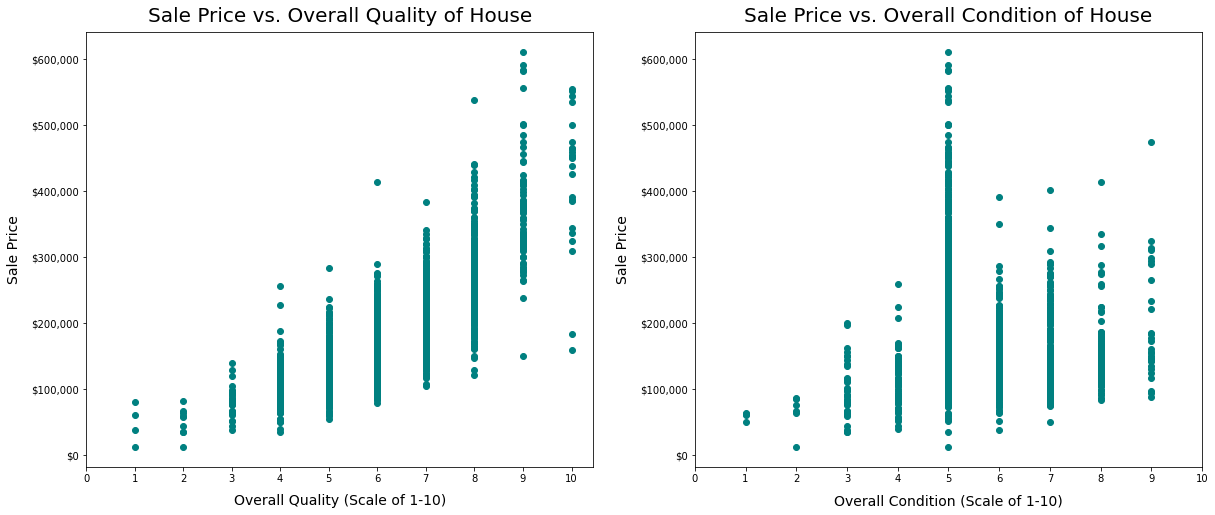

In [41]:
plt.figure(figsize=(20,8))
qual = plt.subplot(1,2,1)
cond = plt.subplot(1,2,2)

qual.scatter(means['overall_qual'],means['saleprice'],color='teal')
qual.set_title('Sale Price vs. Overall Quality of House',fontsize=20,pad=10)
qual.set_xticks(range(11))
qual.set_yticks(range(0,600001,100000))
qual.set_yticklabels(['$0','$100,000','$200,000','$300,000','$400,000','$500,000','$600,000'])
qual.set_xlabel('Overall Quality (Scale of 1-10)',fontsize=14,labelpad=10)
qual.set_ylabel('Sale Price',fontsize=14,labelpad=10)

cond.scatter(means['overall_cond'],means['saleprice'],color='teal')
cond.set_title('Sale Price vs. Overall Condition of House',fontsize=20,pad=10)
cond.set_xticks(range(11))
cond.set_yticks(range(0,600001,100000))
cond.set_yticklabels(['$0','$100,000','$200,000','$300,000','$400,000','$500,000','$600,000'])
cond.set_xlabel('Overall Condition (Scale of 1-10)',fontsize=14,labelpad=10)
cond.set_ylabel('Sale Price',fontsize=14,labelpad=10);

Overall quality and overall condition seem like fairly subjective measurements, but they do seem to have a fairly straight forward effect on sale price, especially overall quality. In the chart on the left, we can see that quality has a pretty obvious and simple positive linear relationship with sale price. With condition on the right, it is a little bit less simple with a big spike in the middle. I assume this is because the condition of the houses are maybe a bit less variable than the quality. A very nice house can be in bad condition and an undesirable home can be perfectly upkept. So a lot of them fall in the middle! And people might be more willing to buy a house with 'good bones' that is also a 'fixer-upper' than a house they don't like as much that's in good condition.

### Can we predict house prices with these variables?
It does seem like there are some fairly strong relationships between these variables and sale prices, so I am optimistic that we will be able to use these are features in our models. It obviously won't be perfect because there are a lot of attributes that a house may have that are subjective and harder to record, such as charm or homey-ness. There are also some attributes that aren't in this dataset that could be helpful, such as color, architecture style, features like jungle gyms, natural features (trees, plants, etc), and probably many more things that I can't think of right now! But overall, I think the data we have will help us construct a model that at least outperforms the baseline.

# Step 3: Feature Selection

First I'm going to create a few functions that I think will be helpful as I go through this process.

In [42]:
def create_X_Z(features,train,test):
    X_tr,X_t,y_tr,y_t = train_test_split(train[features],train['saleprice'],test_size=0.2,random_state=28)
    
    X_sub = test[features]

    
    ss = StandardScaler()
    Z_tr = ss.fit_transform(X_tr)
    Z_t = ss.transform(X_t)
    Z_sub = ss.transform(X_sub)
    
    return X_tr,X_t,y_tr,y_t,Z_tr,Z_t,X_sub,Z_sub

In [43]:
def try_model(estimator,z_or_x,y):
    model = estimator
    model.fit(z_or_x,y)
    return model.score(z_or_x,y)

In [44]:
def model_to_csv(model,z_or_x_test,name):
    csv = test.loc[:,['Id','SalePrice']]
    csv['SalePrice'] = model.predict(z_or_x_test)
    path = './submissions/'+name+'.csv'
    csv.to_csv(path,index=False)

Now that we have those, I am going to do a LASSO model of *all* features and then use the results to do some feature selection.

### Initial LASSO for Feature Selection

I'm going to do this with both datasets to see if one gets a better score than the other and if they use the same features in their predictions.

In [45]:
all_feat = [col for col in means.columns if col not in ['id','saleprice','dataset_train']]

print(len(all_feat))

X_m,X_m_t,y_m,y_m_t,Z_m,Z_m_t,X_m_sub,Z_m_sub = create_X_Z(all_feat,train_m,test_m)

175


In [46]:
l_alphas = np.linspace(0.5, 500, 600)

init_lasso_m = Lasso()

init_lasso_m.fit(Z_m,y_m);

In [47]:
init_lasso_m.score(Z_m,y_m),init_lasso_m.score(Z_m_t,y_m_t)

(0.9013471329082058, 0.8940330273887174)

In [48]:
model_to_csv(init_lasso_m,Z_m_sub,'init_lasso_m') # score: 29542

In [49]:
X_i,X_i_t,y_i,y_i_t,Z_i,Z_i_t,X_i_sub,Z_i_sub = create_X_Z(all_feat,train_i,test_i)

In [50]:
init_lasso_i = Lasso()

init_lasso_i.fit(Z_i,y_i);

In [51]:
print('Train =',round(init_lasso_i.score(Z_i,y_i),4),
      '   Test =',round(init_lasso_i.score(Z_i_t,y_i_t),4),
      '   Difference =',round(init_lasso_i.score(Z_i,y_i)-init_lasso_i.score(Z_i_t,y_i_t),4))

Train = 0.9075    Test = 0.85    Difference = 0.0575


In [52]:
model_to_csv(init_lasso_i,Z_i_sub,'init_lasso_i') # score: 29649

So the model with impute interator method only worked very slightly better, but for simplicity's sake, I am going to use that data going forward. Now I am going to check if the models used the same features, and if they didn't, combine the lists.

In [53]:
coefs_i = list(zip(all_feat,list(init_lasso_i.coef_)))

narrow_feat_i = []

for tup in coefs_i:
    if tup[1] > 0.005 or tup[1] < -0.005:
        narrow_feat_i.append(tup[0])
        
x_narrow_feat_i = []

for tup in coefs_i:
    if tup[1] > 2500 or tup[1] < -2500:
        x_narrow_feat_i.append(tup[0])
        
len(narrow_feat_i), len(x_narrow_feat_i)    

(165, 55)

In [54]:
coefs_m = list(zip(all_feat,list(init_lasso_m.coef_)))

narrow_feat_m = []

for tup in coefs_m:
    if tup[1] > 0.005 or tup[1] < -0.005:
        narrow_feat_m.append(tup[0])
        
x_narrow_feat_m = []

for tup in coefs_m:
    if tup[1] > 2500 or tup[1] < -2500:
        x_narrow_feat_m.append(tup[0])
        
len(narrow_feat_m), len(x_narrow_feat_m)    

(167, 59)

In [55]:
# combining the narrowed feature lists and removing the dataset distinction from the extra narrowed list
nfm = set(narrow_feat_m)
nfi = set(narrow_feat_i)

xnfm = set(x_narrow_feat_m)
xnfi = set(x_narrow_feat_i)

narrow_feat = list(nfm.union(nfi))
x_narrow_feat = list(xnfm.union(xnfi))

Now I'm going to create a `n` (narrowed) and `x` (extra narrowed) version of my X and Z variables.

In [56]:
Xn,Xn_t,yn,yn_t,Zn,Zn_t,Xn_sub,Zn_sub = create_X_Z(narrow_feat,train_i,test_i)

Xx,Xx_t,yx,yx_t,Zx,Zx_t,Xx_sub,Zx_sub = create_X_Z(x_narrow_feat,train_i,test_i)


# Step 4: Modeling!

The number one most important thing in this part is that we outperform the baseline. According to Kaggle, **the RMSE of the baseline model is \\$80,389.42**, so as long as we have a lower error than that, we aren't completely failing.

I know there will be a lot of variance inflation among these features but I'm going to try submitting predictions before and after removing them to see how that affects the model's accuracy. So here we go with the narrowed and extra narrowed feature lists!

In [57]:
lr_n = LinearRegression()
lr_n.fit(Xn,yn)

lr_x = LinearRegression()
lr_x.fit(Xx,yx)

lasso_n = Lasso()
lasso_n.fit(Zn,yn)

lasso_x = Lasso()
lasso_x.fit(Zx,yx)

knn_n = KNeighborsRegressor()
knn_n.fit(Zn,yn)

knn_x = KNeighborsRegressor()
knn_x.fit(Zx,yx);

In [58]:
print('\n',
        'LR N:    Train =',round(lr_n.score(Xn,yn),4),'  Test =',round(lr_n.score(Xn_t,yn_t),4),
      '  Difference =',round(lr_n.score(Xn,yn)-lr_n.score(Xn_t,yn_t),4),'\n',
        'LR X:    Train =',round(lr_x.score(Xx,yx),4),'  Test =',round(lr_x.score(Xx_t,yx_t),4),
      '  Difference =',round(lr_x.score(Xx,yn)-lr_x.score(Xx_t,yx_t),4),'\n',
        'LASSO N: Train =',round(lasso_n.score(Zn,yn),4),'  Test =',round(lasso_n.score(Zn_t,yn_t),4),
      '  Difference =',round(lasso_n.score(Zn,yn)-lasso_n.score(Zn_t,yn_t),4),'\n',
        'LASSO X: Train =',round(lasso_x.score(Zx,yx),4),'  Test =',round(lasso_x.score(Zx_t,yx_t),4),
      '  Difference =',round(lasso_x.score(Zx,yx)-lasso_x.score(Zx_t,yx_t),4),'\n',
        'KNN N:   Train =',round(knn_n.score(Zn,yn),4),'  Test =',round(knn_n.score(Zn_t,yn_t),4),
      '  Difference =',round(knn_n.score(Zn,yn)-knn_n.score(Zn_t,yn_t),4),'\n',
        'KNN X:   Train =',round(knn_x.score(Zx,yx),4),'  Test =',round(knn_x.score(Zx_t,yx_t),4),
     '  Difference =',round(knn_x.score(Zx,yx)-knn_x.score(Zx_t,yx_t),4))


 LR N:    Train = 0.9075   Test = 0.8503   Difference = 0.0572 
 LR X:    Train = 0.8927   Test = 0.8369   Difference = 0.0558 
 LASSO N: Train = 0.9075   Test = 0.8505   Difference = 0.0571 
 LASSO X: Train = 0.8927   Test = 0.837   Difference = 0.0557 
 KNN N:   Train = 0.8569   Test = 0.7651   Difference = 0.0918 
 KNN X:   Train = 0.8668   Test = 0.7658   Difference = 0.1009


In [59]:
model_to_csv(lr_n,Xn_sub,'lr_n') # score: 41242
model_to_csv(lr_x,Xx_sub,'lr_x') # score: 41842

model_to_csv(lasso_n,Zn_sub,'lasso_n') # score: 33743
model_to_csv(lasso_x,Zx_sub,'lasso_x') # score: 32969

model_to_csv(knn_n,Zn_sub,'knn_n')     # score: 38052
model_to_csv(knn_x,Zx_sub,'knn_x')     # score: 36463

For the most part, the models with the extra narrowed features performed better (except for the linear regression which also performed significantly worse than the others, so I'm going to ignore it). So I will mostly use those features going forward! I am going to narrow both lists a bit by taking out the most egregiously inflated variables.

In [60]:
vif_n = pd.DataFrame()
vif_n['vif_factor'] = [variance_inflation_factor(Xn.values, i) for i in range(Xn.shape[1])]
vif_n['features'] = Xn.columns
vif_n['vif_factor'] = round(vif_n['vif_factor'],4)

vif_n[vif_n['vif_factor'] > 20].sort_values('features')

/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/elliotrichardson/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,vif_factor,features
15,inf,1st_flr_sf
100,inf,2nd_flr_sf
47,inf,bsmt_unf_sf
72,inf,bsmtfin_sf_1
126,inf,bsmtfin_sf_2
4,inf,exterior_1st_CBlock
73,4.872280e+01,exterior_1st_CemntBd
136,4.915040e+01,exterior_1st_HdBoard
31,7.299070e+01,exterior_1st_MetalSd
67,2.633290e+01,exterior_1st_Plywood


In [61]:
bad_n = list(vif_n.loc[vif_n['vif_factor'] > 20,'features'])

narrow_feat2 = [feat for feat in narrow_feat if feat not in bad_n]

In [62]:
vif_x = pd.DataFrame()
vif_x['vif_factor'] = [variance_inflation_factor(Xx.values, i) for i in range(Xx.shape[1])]
vif_x['features'] = Xx.columns
vif_x['vif_factor'] = round(vif_x['vif_factor'],4)

vif_x[vif_x['vif_factor'] > 20].sort_values('features')

,vif_factor,features
24,676.9092,1st_flr_sf
28,127.0144,2nd_flr_sf
59,44.1417,bsmt_qual
32,120.8181,exter_qual
53,42.4621,exterior_1st_CemntBd
42,28.8925,exterior_1st_MetalSd
46,48.0859,exterior_1st_VinylSd
18,41.9517,exterior_2nd_CmentBd
40,27.0644,exterior_2nd_MetalSd
41,44.3605,exterior_2nd_VinylSd


In [63]:
bad_x = list(vif_x.loc[vif_x['vif_factor'] > 20,'features'])

x_narrow_feat2 = [feat for feat in x_narrow_feat if feat not in bad_x]

In [64]:
len(x_narrow_feat2),len(narrow_feat2)

(40, 130)

In [65]:
# resetting the X and Z variables with the updated lists

Xn,Xn_t,yn,yn_t,Zn,Zn_t,Xn_sub,Zn_sub = create_X_Z(narrow_feat2,train_i,test_i)
Xx,Xx_t,yx,yx_t,Zx,Zx_t,Xx_sub,Zx_sub = create_X_Z(x_narrow_feat2,train_i,test_i)

yn_log = yn.map(np.log)
yx_log = yx.map(np.log)

ynt_log = yn_t.map(np.log)
yxt_log = yx_t.map(np.log)

Okay, I have narrowed the features even further and I'm going to try again with LASSO and KNN!

In [66]:
lasso_n = Lasso()
lasso_n.fit(Zn,yn)

lasso_x = Lasso()
lasso_x.fit(Zx,yx)

knn_n = KNeighborsRegressor()
knn_n.fit(Zn,yn)

knn_x = KNeighborsRegressor()
knn_x.fit(Zx,yx);

In [67]:
print('\n',
        'LASSO N: Train =',round(lasso_n.score(Zn,yn),4),'  Test =',round(lasso_n.score(Zn_t,yn_t),4),
      '  Difference =',round(lasso_n.score(Zn,yn)-lasso_n.score(Zn_t,yn_t),4),'\n',
        'LASSO X: Train =',round(lasso_x.score(Zx,yx),4),'  Test =',round(lasso_x.score(Zx_t,yx_t),4),
      '  Difference =',round(lasso_x.score(Zx,yx)-lasso_x.score(Zx_t,yx_t),4),'\n',
        'KNN N:   Train =',round(knn_n.score(Zn,yn),4),'  Test =',round(knn_n.score(Zn_t,yn_t),4),
      '  Difference =',round(knn_n.score(Zn,yn)-knn_n.score(Zn_t,yn_t),4),'\n',
        'KNN X:   Train =',round(knn_x.score(Zx,yx),4),'  Test =',round(knn_x.score(Zx_t,yx_t),4),
     '  Difference =',round(knn_x.score(Zx,yx)-knn_x.score(Zx_t,yx_t),4))


 LASSO N: Train = 0.8904   Test = 0.8342   Difference = 0.0562 
 LASSO X: Train = 0.77   Test = 0.6592   Difference = 0.1108 
 KNN N:   Train = 0.8422   Test = 0.729   Difference = 0.1133 
 KNN X:   Train = 0.8167   Test = 0.6957   Difference = 0.121


In [68]:
model_to_csv(lasso_n,Zn_sub,'lasso_n2') # score: 43122
model_to_csv(lasso_x,Zx_sub,'lasso_x2') # score: 50779

model_to_csv(knn_n,Zn_sub,'knn_n2')     # score: 47656
model_to_csv(knn_x,Zx_sub,'knn_x2')     # score: 52219

Unfortunately, the model got worse which is a huge bummer. I'm going to try again with `y_log` and hope for the best!

In [69]:
lr_n = LinearRegression()
lr_n.fit(Xn,yn_log)

lr_x = LinearRegression()
lr_x.fit(Xx,yx_log)

lasso_n = Lasso()
lasso_n.fit(Xn,yn_log)

lasso_x = Lasso()
lasso_x.fit(Xx,yx_log)

knn_n = KNeighborsRegressor()
knn_n.fit(Zn,yn_log)

knn_x = KNeighborsRegressor()
knn_x.fit(Zx,yx_log);

In [70]:
print('\n',
        'LR N:    Train =',round(lr_n.score(Xn,yn_log),4),'  Test =',round(lr_n.score(Xn_t,ynt_log),4),
      '  Difference =',round(lr_n.score(Xn,yn_log)-lr_n.score(Xn_t,ynt_log),4),'\n',
        'LR X:    Train =',round(lr_x.score(Xx,yx_log),4),'   Test =',round(lr_x.score(Xx_t,yxt_log),4),
      '  Difference =',round(lr_x.score(Xx,yx_log)-lr_x.score(Xx_t,yxt_log),4),'\n',
        'LASSO N: Train =',round(lasso_n.score(Xn,yn_log),4),'  Test =',round(lasso_n.score(Xn_t,ynt_log),4),
      '  Difference =',round(lasso_n.score(Xn,yn_log)-lasso_n.score(Zn_t,ynt_log),4),'\n',
        'LASSO X: Train =',round(lasso_x.score(Xx,yx_log),4),'  Test =',round(lasso_x.score(Xx_t,yxt_log),4),
      '  Difference =',round(lasso_x.score(Xx,yx_log)-lasso_x.score(Xx_t,yxt_log),4),'\n',
        'KNN N:   Train =',round(knn_n.score(Zn,yn_log),4),'  Test =',round(knn_n.score(Zn_t,ynt_log),4),
      '  Difference =',round(knn_n.score(Zn,yn_log)-knn_n.score(Zn_t,ynt_log),4),'\n',
        'KNN X:   Train =',round(knn_x.score(Zx,yx_log),4),'  Test =',round(knn_x.score(Zx_t,yxt_log),4),
     '  Difference =',round(knn_x.score(Zx,yx_log)-knn_x.score(Zx_t,yxt_log),4))


 LR N:    Train = 0.9017   Test = 0.8536   Difference = 0.0481 
 LR X:    Train = 0.7277    Test = 0.586   Difference = 0.1416 
 LASSO N: Train = 0.6525   Test = 0.6322   Difference = 662.0573 
 LASSO X: Train = 0.42   Test = 0.4597   Difference = -0.0397 
 KNN N:   Train = 0.8295   Test = 0.6878   Difference = 0.1416 
 KNN X:   Train = 0.7899   Test = 0.6336   Difference = 0.1563


In [71]:
# creating a new version for log models that includes the conversion back to dollars

def log_to_csv(model,z_or_x_test,name):
    csv = test.loc[:,['Id','SalePrice']]
    preds = model.predict(z_or_x_test)
    csv['SalePrice'] = np.exp(preds)
    path = './submissions/'+name+'.csv'
    csv.to_csv(path,index=False)

In [72]:
log_to_csv(lr_n,Xn_sub,'lr_n_log') # score: 51209
log_to_csv(lr_x,Xx_sub,'lr_x_log') # score: 40930

log_to_csv(lasso_n,Zn_sub,'lasso_n_log') # score: 51000
log_to_csv(lasso_x,Zx_sub,'lasso_x_log') # score: 40707

log_to_csv(knn_n,Zn_sub,'knn_n_log')     # score: 48370
log_to_csv(knn_x,Zx_sub,'knn_x_log')     # score: ???

I'm going to try manually selecting some features!

In [73]:
features = ['lot_area',
 'sale_type_New',
 'overall_qual',
 'neighborhood_Blueste',
 'neighborhood_BrDale',
 'neighborhood_BrkSide',
 'neighborhood_ClearCr',
 'neighborhood_CollgCr',
 'neighborhood_Crawfor',
 'neighborhood_Edwards',
 'neighborhood_Gilbert',
 'neighborhood_Greens',
 'neighborhood_GrnHill',
 'neighborhood_IDOTRR',
 'neighborhood_Landmrk',
 'neighborhood_MeadowV',
 'neighborhood_Mitchel',
 'neighborhood_NAmes',
 'neighborhood_NPkVill',
 'neighborhood_NWAmes',
 'neighborhood_NoRidge',
 'neighborhood_NridgHt',
 'neighborhood_OldTown',
 'neighborhood_SWISU',
 'neighborhood_Sawyer',
 'neighborhood_SawyerW',
 'neighborhood_Somerst',
 'neighborhood_StoneBr',
 'neighborhood_Timber',
 'neighborhood_Veenker',
 'ms_zoning_C (all)',
 'ms_zoning_FV',
 'ms_zoning_I (all)',
 'ms_zoning_RH',
 'ms_zoning_RL',
 'ms_zoning_RM']

In [74]:
# going to add in the extra narrowed features too

fs = set(features)
xnf = set(x_narrow_feat)

feats = fs.union(xnf)
len(feats)

85

In [75]:
ss = StandardScaler()

Xf,Xf_t,yf,yf_t,Zf,Zf_t,Xf_sub,Zf_sub = create_X_Z(fs,train_i,test_i)

lasso_f = Lasso()

lasso_f.fit(Zf,yf)

print('Train =',round(lasso_f.score(Zf,yf),4),'   Test =',round(lasso_f.score(Zf_t,yf_t),4),
      '   Difference =',round(lasso_f.score(Zf,yf)-lasso_f.score(Zf_t,yf_t),4))

Train = 0.7746    Test = 0.7119    Difference = 0.0627


In [76]:
model_to_csv(lasso_f,Zf_sub,'lasso_f') # score: ???

I'm not sure what else to try so I'm going to move on.

# Step 5: Conclusions

In conclusion, the best model was the initial one I created for feature selection. This was really frustrating for me because I felt like I was doing what I was supposed to by removing columns that were creating multicollinearity and noise, but the model just kept getting worse as I removed features. But I guess if I was going to recommend a model to the real estate company, I would recommend the LASSO model with the extra narrowed feature list. I will recreate it below! This model did fairly well on both the train and test data with the smallest difference between those two scores. That makes me think it will be the most generalizable of all the models I created while still maintaining fairly accurate predictions. 

In [77]:
Xx,Xx_t,yx,yx_t,Zx,Zx_t,Xx_sub,Zx_sub = create_X_Z(x_narrow_feat,train_i,test_i)

lasso_x = Lasso()
lasso_x.fit(Zx,yx)

print('LASSO X: Train =',round(lasso_x.score(Zx,yx),4),'  Test =',round(lasso_x.score(Zx_t,yx_t),4),
      '  Difference =',round(lasso_x.score(Zx,yx)-lasso_x.score(Zx_t,yx_t),4))

LASSO X: Train = 0.8927   Test = 0.837   Difference = 0.0557


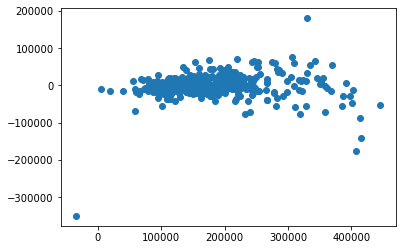

In [78]:
y_pred = lasso_x.predict(Zx_t)
resids = y_pred - yx_t

plt.scatter(y_pred,resids);

In [79]:
mse = metrics.mean_squared_error(yx_t, y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:',round(mse,2),' |  Root Mean Squared Error ($):',"${:,.2f}".format(rmse))

Mean Squared Error: 1062911936.4  |  Root Mean Squared Error ($): $32,602.33


Looking at this, it definitely seems like there is something I'm missing in my model. I'm really running out of time but **I'm going to try adding some polynomials just in case.**

In [80]:
Xp = i_df[x_narrow_feat]

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(Xp)
poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(x_narrow_feat))
poly_df.reset_index

full_df = poly_df.merge(i_df.loc[:,['id','saleprice','dataset_train']],left_index=True,right_index=True)

In [81]:
poly_train = full_df[full_df['dataset_train'] == 1]
poly_test = full_df[full_df['dataset_train'] == 0]

Xp = poly_train.drop(columns=['saleprice','id','dataset_train'])
Xp_sub = poly_test.drop(columns=['saleprice','id','dataset_train'])

yp = poly_train['saleprice']

In [82]:
lasso_p = Lasso()
lasso_p.fit(Xp,yp)

lasso_p.score(Xp,yp)

0.9831603046846362

In [83]:
coefs_p = list(zip(poly_df.columns,list(lasso_p.coef_)))

narrow_feat_p = []

for tup in coefs_p:
    if tup[1] > 1000 or tup[1] < -1000:
        narrow_feat_p.append(tup[0])
        
len(narrow_feat_p)  

781

In [84]:
Xpn,Xpn_t,ypn,ypn_t,Zpn,Zpn_t,Xpn_sub,Zpn_sub = create_X_Z(narrow_feat_p,poly_train,poly_test)

lasso_pn = Lasso()
lasso_pn.fit(Xpn,ypn)

lasso_pn.score(Xpn,ypn),lasso_pn.score(Xpn_t,ypn_t)

(0.95215306608702, 0.7481197614195985)

In [85]:
model_to_csv(lasso_pn,Xpn_sub,'lasso_pn') # score: 31612

In [86]:
y_p_pred = lasso_pn.predict(Xpn_t)
resids_p = y_p_pred - ypn_t

mse_p = metrics.mean_squared_error(ypn_t, y_p_pred)
rmse_p = np.sqrt(mse_p)

print('Mean Squared Error:',round(mse_p,2),' |  Root Mean Squared Error ($):',"${:,.2f}".format(rmse_p))

Mean Squared Error: 1642650296.8  |  Root Mean Squared Error ($): $40,529.62


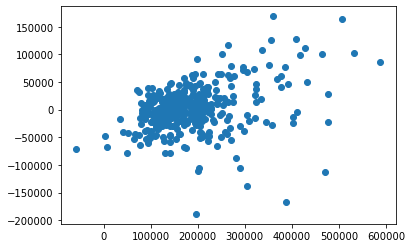

In [87]:
plt.scatter(y_p_pred,resids_p);

In [88]:
print('Train =',round(lasso_pn.score(Xpn,ypn),4),'  Test =',round(lasso_pn.score(Xpn_t,ypn_t),4),
      '  Difference =',round(lasso_pn.score(Xpn,ypn)-lasso_pn.score(Xpn_t,ypn_t),4))

Train = 0.9522   Test = 0.7481   Difference = 0.204


Okay nevermind! Back to `lasso_x`.

# Step 5: Conclusions (for real this time!)
So yeah, like I said earlier, this model seems to be the best cross of generalizable and accurate.

In [89]:
print('LASSO X: Train =',round(lasso_x.score(Zx,yx),4),'  Test =',round(lasso_x.score(Zx_t,yx_t),4),
      '  Difference =',round(lasso_x.score(Zx,yx)-lasso_x.score(Zx_t,yx_t),4))

print('Mean Squared Error:',round(mse,2),' |  Root Mean Squared Error ($):',"${:,.2f}".format(rmse))

LASSO X: Train = 0.8927   Test = 0.837   Difference = 0.0557
Mean Squared Error: 1062911936.4  |  Root Mean Squared Error ($): $32,602.33


## Is this useful?

Our RMSE for this model, (\\$32,602.33) is significantly smaller then the baseline (\\$80,389.42) but it's still not negligible by any means. With a RMSE of \\$32,602.33, we can give the real estate company a range of plus or minus \\$30,000 or so.  For example, if the model predicted a house would be \\$200,000, we could produce a range of \\$170,000-\\$230,000. This will allow a realtor to use their discretion is setting a price for the house, but set a more objective foundation for that realtor to base the price on. I was hoping to create a more accurate model so that the range would be smaller and more precise, but I still think this can be a useful tool for realtors to use to double check their gut instincts.